VAEを用いて顔画像の欠損補完を試す

In [16]:
!pip -q install -U datasets pillow tqdm

import os, math, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from PIL import Image

In [27]:
# ---------------------------
# 1 Repro / Device
# ---------------------------
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [28]:
# ---------------------------
# 2 Load cifar10 (free)
# ---------------------------
from datasets import load_dataset

train_hf = load_dataset("nielsr/CelebA-faces", split="train[:30000]")
valid_hf = load_dataset("nielsr/CelebA-faces", split="train[30000:33000]")

In [29]:
# ---------------------------
# 3 Dataset wrapper
# ---------------------------
class CelebAInpaintDataset(Dataset):
    def __init__(self, hf_ds, image_size=64):
        self.ds = hf_ds
        self.image_size = image_size

    def __len__(self):
        return len(self.ds)

    def _preprocess(self, pil_img: Image.Image) -> torch.Tensor:
        # CelebAは顔が中心に寄ってるので、まず中央Crop→64に縮小が無難
        # 元は178x218。中央を正方形にしてから64へ。
        w, h = pil_img.size
        side = min(w, h)
        left = (w - side) // 2
        top  = (h - side) // 2
        pil_img = pil_img.crop((left, top, left + side, top + side))
        pil_img = pil_img.resize((self.image_size, self.image_size), Image.BILINEAR)

        arr = np.array(pil_img).astype(np.float32) / 255.0  # (H,W,3) [0,1]
        arr = np.transpose(arr, (2, 0, 1))                  # (3,H,W)
        return torch.from_numpy(arr)

    def _center_mask(self, x: torch.Tensor) -> torch.Tensor:
        # x: (3, H, W)
        _, H, W = x.shape
        mask = torch.ones_like(x)
        h0, h1 = H // 3, 2 * H // 3
        w0, w1 = W // 3, 2 * W // 3
        mask[:, h0:h1, w0:w1] = 0.0
        return mask

    def __getitem__(self, idx):
        img = self.ds[idx]["image"]  # PIL
        x = self._preprocess(img)    # (3,64,64)

        mask = self._center_mask(x)
        x_masked = x * mask

        return x_masked, x, mask     # 入力(欠損), 正解(元), mask

In [30]:
# ---------------------------
# 4 DataLoader
# ---------------------------
image_size = 64
batch_size = 128

train_ds = CelebAInpaintDataset(train_hf, image_size=image_size)
valid_ds = CelebAInpaintDataset(valid_hf, image_size=image_size)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print("train:", len(train_ds), "valid:", len(valid_ds))

train: 30000 valid: 3000


In [41]:
# ---------------------------
# 5 Conv-VAE
#   - decoderはlogits出力（sigmoidしない）
#   - lossは BCEWithLogits + KL
# ---------------------------
class ConvVAE(nn.Module):
    def __init__(self, z_dim=64, img_ch=3):
        super().__init__()
        self.z_dim = z_dim

        # Encoder: (3,64,64) -> (256,4,4)
        self.enc = nn.Sequential(
            nn.Conv2d(img_ch, 32, 4, 2, 1),  # 32x32
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),      # 16x16
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1),     # 8x8
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1),    # 4x4
            nn.ReLU(True),
        )
        self.enc_fc = nn.Linear(256 * 4 * 4, 512)
        self.mu = nn.Linear(512, z_dim)
        self.logvar = nn.Linear(512, z_dim)

        # Decoder: z -> (256,4,4) -> (3,64,64) logits
        self.dec_fc = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.ReLU(True),
            nn.Linear(512, 256 * 4 * 4),
            nn.ReLU(True),
        )
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 8x8
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 16x16
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # 32x32
            nn.ReLU(True),
            nn.ConvTranspose2d(32, img_ch, 4, 2, 1) # 64x64 logits
        )

    def encode(self, x):
        h = self.enc(x)
        h = h.view(h.size(0), -1)
        h = F.relu(self.enc_fc(h))
        mu = self.mu(h)
        logvar = self.logvar(h)
        return mu, logvar

    def reparam(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + std * eps
        return mu

    def decode_logits(self, z):
        h = self.dec_fc(z)
        h = h.view(h.size(0), 256, 4, 4)
        logits = self.dec(h)
        return logits

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        logits = self.decode_logits(z)
        return logits, mu, logvar

    def loss(self, x_masked, x_target, mask, beta=1.0):
        logits, mu, logvar = self.forward(x_masked)

        bce = F.binary_cross_entropy_with_logits(logits, x_target, reduction="none")  # (B,3,H,W)
        miss = (1.0 - mask)  # 欠損部分=1

        # 欠損部分のrecon
        denom_m = torch.sum(miss, dim=(1,2,3)).clamp(min=1.0)
        recon_miss = torch.sum(bce * miss, dim=(1,2,3)) / denom_m

        # 全体のrecon（弱めに入れて“顔らしさ”を保つ）
        recon_all = torch.mean(torch.sum(bce, dim=(1,2,3)))

        lam = 0.9  # 欠損重視。0.7〜0.95で調整
        recon = torch.mean(lam * recon_miss + (1.0 - lam) * recon_all)

        # KL
        kl = -0.5 * torch.mean(torch.sum(1 + logvar - mu**2 - torch.exp(logvar), dim=1))

        loss = recon + beta * kl
        return loss, recon, kl

In [42]:
# ---------------------------
# 6 Train
# ---------------------------
z_dim = 128
model = ConvVAE(z_dim=z_dim).to(device)
opt = torch.optim.Adam(model.parameters(), lr=2e-4)

epochs = 10
beta = 0.05

def eval_epoch():
    model.eval()
    losses, recons, kls = [], [], []
    with torch.no_grad():
        for x_masked, x, mask in valid_loader:
            x_masked = x_masked.to(device, non_blocking=True)
            x = x.to(device, non_blocking=True)
            loss, recon, kl = model.loss(x_masked, x, mask.to(device), beta=beta)
            losses.append(loss.item())
            recons.append(recon.item())
            kls.append(kl.item())
    return float(np.mean(losses)), float(np.mean(recons)), float(np.mean(kls))

for ep in range(1, epochs+1):
    model.train()
    pbar = tqdm(train_loader, desc=f"epoch {ep}/{epochs}")
    losses, recons, kls = [], [], []
    for x_masked, x, mask in pbar:
        x_masked = x_masked.to(device, non_blocking=True)
        x = x.to(device, non_blocking=True)

        opt.zero_grad(set_to_none=True)
        loss, recon, kl = model.loss(x_masked, x, mask.to(device), beta=beta)
        loss.backward()
        opt.step()

        losses.append(loss.item())
        recons.append(recon.item())
        kls.append(kl.item())
        pbar.set_postfix(loss=np.mean(losses), recon=np.mean(recons), kl=np.mean(kls))

    v_loss, v_recon, v_kl = eval_epoch()
    print(f"[VALID] loss={v_loss:.3f} recon={v_recon:.3f} kl={v_kl:.3f}")

epoch 1/10:   0%|          | 0/235 [00:00<?, ?it/s]

[VALID] loss=709.977 recon=706.485 kl=69.840


epoch 2/10:   0%|          | 0/235 [00:00<?, ?it/s]

[VALID] loss=683.937 recon=679.345 kl=91.831


epoch 3/10:   0%|          | 0/235 [00:00<?, ?it/s]

[VALID] loss=676.105 recon=671.288 kl=96.350


epoch 4/10:   0%|          | 0/235 [00:00<?, ?it/s]

[VALID] loss=670.115 recon=664.897 kl=104.360


epoch 5/10:   0%|          | 0/235 [00:00<?, ?it/s]

[VALID] loss=665.527 recon=660.319 kl=104.156


epoch 6/10:   0%|          | 0/235 [00:00<?, ?it/s]

[VALID] loss=660.994 recon=655.615 kl=107.588


epoch 7/10:   0%|          | 0/235 [00:00<?, ?it/s]

[VALID] loss=659.940 recon=654.493 kl=108.938


epoch 8/10:   0%|          | 0/235 [00:00<?, ?it/s]

[VALID] loss=655.016 recon=649.620 kl=107.918


epoch 9/10:   0%|          | 0/235 [00:00<?, ?it/s]

[VALID] loss=651.974 recon=646.473 kl=110.013


epoch 10/10:   0%|          | 0/235 [00:00<?, ?it/s]

[VALID] loss=651.419 recon=645.847 kl=111.447


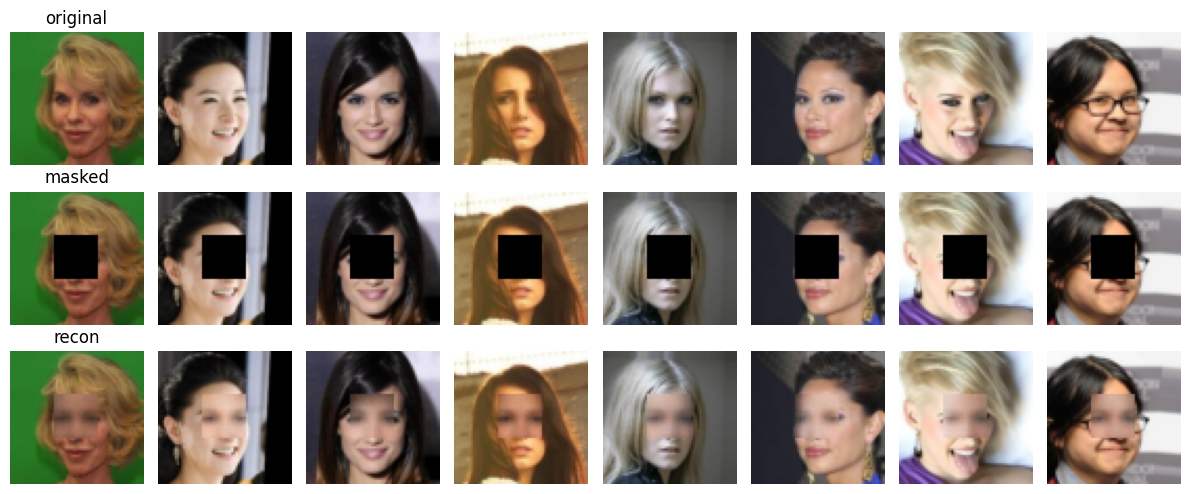

In [43]:
# ---------------------------
# 7 Visualize inpainting results (3列: original / masked / recon)
# ---------------------------
import matplotlib.pyplot as plt

def to_img(t):
    # (3,H,W) tensor [0,1] -> (H,W,3) np
    t = t.detach().cpu().clamp(0,1)
    return np.transpose(t.numpy(), (1,2,0))

model.eval()
x_masked, x, mask = next(iter(valid_loader))
x_masked = x_masked.to(device)
x = x.to(device)

with torch.no_grad():
    logits, _, _ = model(x_masked)
    recon = torch.sigmoid(logits)
    recon = recon * (1.0 - mask.to(device)) + x_masked * mask.to(device)

n_show = 8
plt.figure(figsize=(12, 5))
for i in range(n_show):
    # original
    plt.subplot(3, n_show, 1 + i)
    plt.imshow(to_img(x[i]))
    plt.axis("off")
    if i == 0: plt.title("original")

    # masked
    plt.subplot(3, n_show, 1 + n_show + i)
    plt.imshow(to_img(x_masked[i]))
    plt.axis("off")
    if i == 0: plt.title("masked")

    # recon
    plt.subplot(3, n_show, 1 + 2*n_show + i)
    plt.imshow(to_img(recon[i]))
    plt.axis("off")
    if i == 0: plt.title("recon")
plt.tight_layout()
plt.show()